0.575

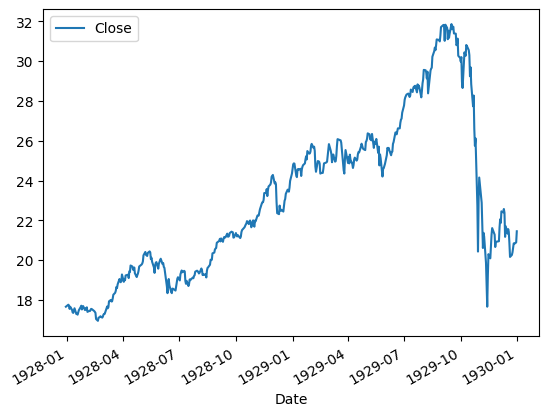

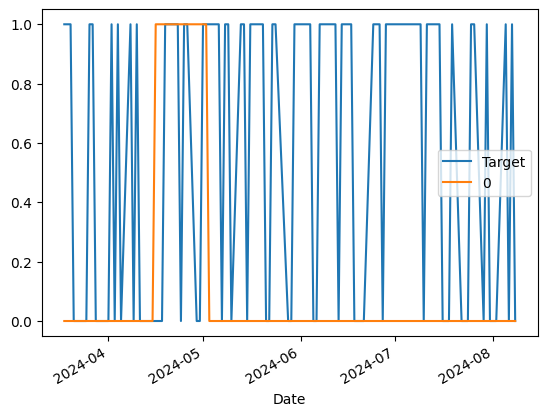

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt

sp500 = yf.Ticker("^GSPC") # download the data for the s&p500 (symbol is GSPC)

sp500 = sp500.history(period="max") # query all data from the beginning when the index was created
# interval="1m"
sp500

sp500.tail()

sp500.index # left column; allows us to slice the data frame easily

sp500[:500].plot.line(y="Close", use_index=True) # y-axis is closing price, x axis is date

# clean data and remove unwanted (these two are more specific to individual stocks, not the index)
del sp500['Dividends']
del sp500["Stock Splits"]

# target (what we want to predict): will the index go up or down tomorrow?
# create column that tells us tomorrow's price; pandas shift to get tomorrow's closing on today's row
sp500['Tomorrow'] = sp500['Close'].shift(-1)
sp500

# create the target column; 1 if price goes up, 0 if down
sp500['Target'] = (sp500['Tomorrow'] > sp500['Close']).astype(int) # cast since maching learning for integers
sp500

# when predicting, want to remove the earlier data from when the stock was fundamentally different
sp500 = sp500.loc["1990-01-01":].copy() # use copy to make pandas happy
sp500

# random forests; take many individual decision trees with random parameters and average the results
# random forests make it harder for overfitting to occur
# run quickly 
# can pick up non-linear tendencies (here, for example, non-linear relationship between target and close)
from sklearn.ensemble import RandomForestClassifier

# n_estimators: how many individual decision trees
# min_samples_split: stop the decision tree if they go to deep; prevent overfitting
# random_state: is the seed for generating; good to keep it the same so that if you improve your model, it'll be consistent enough to notice the changes
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# when you split into training and testing, can't use cross validation in this case because the data is time series
# if you use cross validation, may be using the future to be predicting the past (called leakage since you are leaking information into the model)
# leakage example: if I ask you to predict the price tomorrow and I give you the price in 30 days, you'll probably do better

# simple way to split it: last 100 rows are testing
# we'll improve later
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ['Close', 'Volume', 'Open', 'High', 'Low'] # don't want to use the target or tomorrow since that'll result in overfitting
model.fit(train[predictors], train['Target'])

# evaluate the model
from sklearn.metrics import precision_score # if the model says target is 0, is it actually?
# this is a good metric for this because we know that if we buy the stock, we want it to increase

preds = model.predict(test[predictors])

import pandas as pd
preds = pd.Series(preds, index=test.index) # turn into pandas series so it's easier to look at

preds

precision_score(test["Target"], preds)

# plot the values we got and the actual values
combined = pd.concat([test["Target"], preds], axis=1) # axis is treat each of these inputs as a column in our data set
combined.plot()

# backtesting
# you want to test the model not just on the 100 latest days, but also look at how it can handle many years of data

# define function for everything we just did
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=2500, step=250): 
    # when you backtest, you want a certain amount of data to train your first model with
    # start=2500 means train your first model with 10 years of data (250 trading days a year)
    # step=2500 means you increment by one year
    # what this will do: use 10 years of data to predict the 11th year. Then take 11 years to predict 12th year, etc. 
    all_predictions = [] 

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

predictions = backtest(sp500, model, predictors)

predictions["Predictions"].value_counts()

precision_score(predictions["Target"], predictions["Predictions"])

# actual percentage of how many days went up
predictions["Target"].value_counts() / predictions.shape[0]

# adding more predictors

# you might want to look at what the stock did a week, a month, a year, etc. before
horizons = [2,5,60,250,1000] # calculate the mean close price in the past 2 days, 5 days, etc.
# we want to find the ratio between today's closing price and the closing price in those periods which will help us know if the market is due for an upswing, etc.

new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"] # ratio between today's vs. the rolling avg of the past 2 days, 5 days, etc. 

    trend_column = f"Trend_{horizon}" # number of days in the past x days where the stock price actually went up
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"] 

    new_predictors += [ratio_column, trend_column]

sp500 = sp500.dropna() # gets rid of NaN (when there are no days prior to that day to look at)

sp500.tail()

model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

# rewrite our predict function so that it gives the probability that it'll go up (not just 0s and 1s)
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1 # returns 1 if the probability is high enough
    preds[preds < .6] = 0
    # we use .6 for the model to be confident that it'll go up (so it'll reduce the number of 1s we get, but those 1s are more likely to actually be up)
    
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

# do the backtesting again but with the ratios (the high, low, open, etc. are all absolute, i.e., don't say anything about tomorrow or day before)
predictions = backtest(sp500, model, new_predictors)

predictions["Predictions"].value_counts()

precision_score(predictions["Target"], predictions["Predictions"])

So this improved model makes it so that there are fewer days that the model predicts it'll go up, but those days have more percentage of actually going up.

Next Steps:
- Look at other indices that are open while the sp500 is not (sp500 open only in US trading hours). If the prices of other indices are increasing, does that correlate with sp500 also increasing?
- Add news about general macroeconomic conditions (e.g. interest rates, inflation).
- Look within the sp500 at specific industries (e.g. if tech has a downturn, sp500 will probably have one later on)
- Increase resolution (hour by hour data, minute by minute data, etc.)



So this improved model makes it so that there are fewer days that the model predicts it'll go up, but those days have more percentage of actually going up.

Next Steps:
- Look at other indices that are open while the sp500 is not (sp500 open only in US trading hours). If the prices of other indices are increasing, does that correlate with sp500 also increasing?
- Add news about general macroeconomic conditions (e.g. interest rates, inflation).
- Look within the sp500 at specific industries (e.g. if tech has a downturn, sp500 will probably have one later on)
- Increase resolution (hour by hour data, minute by minute data, etc.)